In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import chess 



### Предсказание результата шахматной партии с использованием Knn и логистической регрессии

Цель: научиться предсказывать результат шахматной партии по информации о соперниках.

Для обучения использован датасет

https://www.kaggle.com/datasets/thomaswesthead/120000-chess-games-lichess/data?select=lichess_db_standard_rated_2013-01.pgn

## Обработка датасета


Для получения наиболее полной информации самостоятельно обработаем исходную информацию из png файла, выделяя сразу только необходимые поля. Так же выделим поле "opening", которого нет в csv файле

In [3]:
import chess.pgn as chess

pgn_file = open('datasets/lichess_db_standard_rated_2013-01.pgn')

# Инициализируем список для хранения данных о партиях

def extract_game_data(game):
    """
    Извлекает необходимые данные из игры и возвращает их в виде словаря.
    """
    return {
        "event": game.headers.get("Event"),
        "result": game.headers.get("Result"),
        "white_elo": game.headers.get("WhiteElo"),
        "black_elo": game.headers.get("BlackElo"),
        "termination": game.headers.get("Termination"),
        "time_control": game.headers.get("TimeControl"),
        "opening": game.headers.get("Opening"),
    }

# Открываем файл PGN

# Инициализируем список для хранения данных о партиях
games_data = []

# Читаем и парсим партии из файла
while True:
    game = chess.read_game(pgn_file)
    if game is None:
        break

    # Извлекаем данные игры
    game_data = extract_game_data(game)
    
    # Проверяем, что все необходимые поля присутствуют
    if all(game_data.values()):
        games_data.append(game_data)

# Закрываем файл
pgn_file.close()

# Создаем DataFrame из собранных данных
data = pd.DataFrame(games_data)


data.head()

,event,result,white_elo,black_elo,termination,time_control,opening
0,Rated Classical game,1-0,1639,1403,Normal,600+8,French Defense: Normal Variation
1,Rated Classical game,1-0,1654,1919,Normal,480+2,"Queen's Pawn Game: Colle System, Anti-Colle"
2,Rated Classical game,1-0,1643,1747,Normal,420+17,Four Knights Game: Italian Variation
3,Rated Bullet game,0-1,1824,1973,Normal,60+1,Caro-Kann Defense: Goldman Variation
4,Rated Bullet game,0-1,1765,1815,Normal,60+1,French Defense: La Bourdonnais Variation


Проверим датасет на наличие пропущенных значений

In [4]:
print(data.isnull().sum())


event           0
result          0
white_elo       0
black_elo       0
termination     0
time_control    0
opening         0
dtype: int64


Как видно пропущенных значений нет.

Теперь перейдем к обработке датасета для последующего обучения


# Преобразование значений в числовой формат

* результат партии:

In [5]:
result_mapping = {
    '1-0': 1,  # Победа белых
    '0-1': 2,  # Победа черных
    '1/2-1/2': 0  # Ничья
}
data['result'] = data['result'].replace(result_mapping)
data.head()

/tmp/ipykernel_17504/3029925040.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['result'] = data['result'].replace(result_mapping)


,event,result,white_elo,black_elo,termination,time_control,opening
0,Rated Classical game,1,1639,1403,Normal,600+8,French Defense: Normal Variation
1,Rated Classical game,1,1654,1919,Normal,480+2,"Queen's Pawn Game: Colle System, Anti-Colle"
2,Rated Classical game,1,1643,1747,Normal,420+17,Four Knights Game: Italian Variation
3,Rated Bullet game,2,1824,1973,Normal,60+1,Caro-Kann Defense: Goldman Variation
4,Rated Bullet game,2,1765,1815,Normal,60+1,French Defense: La Bourdonnais Variation


* контроль времени:

In [6]:
data[['base_time', 'increment']] = data['time_control'].str.split('+', expand=True)
data.drop(columns=['time_control'], inplace=True)
data['increment'].fillna(0, inplace=True)
data.head()

/tmp/ipykernel_17504/2261493385.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['increment'].fillna(0, inplace=True)


,event,result,white_elo,black_elo,termination,opening,base_time,increment
0,Rated Classical game,1,1639,1403,Normal,French Defense: Normal Variation,600,8
1,Rated Classical game,1,1654,1919,Normal,"Queen's Pawn Game: Colle System, Anti-Colle",480,2
2,Rated Classical game,1,1643,1747,Normal,Four Knights Game: Italian Variation,420,17
3,Rated Bullet game,2,1824,1973,Normal,Caro-Kann Defense: Goldman Variation,60,1
4,Rated Bullet game,2,1765,1815,Normal,French Defense: La Bourdonnais Variation,60,1


* результат завершения партии:

In [7]:
termination_mapping = {
    'Normal' : 1,  # мат, сдача
    'Time forfeit' : 0  # вышло время
}
data['termination'] = data['termination'].replace(termination_mapping)
data.head()

/tmp/ipykernel_17504/2081659562.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['termination'] = data['termination'].replace(termination_mapping)


,event,result,white_elo,black_elo,termination,opening,base_time,increment
0,Rated Classical game,1,1639,1403,1,French Defense: Normal Variation,600,8
1,Rated Classical game,1,1654,1919,1,"Queen's Pawn Game: Colle System, Anti-Colle",480,2
2,Rated Classical game,1,1643,1747,1,Four Knights Game: Italian Variation,420,17
3,Rated Bullet game,2,1824,1973,1,Caro-Kann Defense: Goldman Variation,60,1
4,Rated Bullet game,2,1765,1815,1,French Defense: La Bourdonnais Variation,60,1


* вид партии:

In [8]:

pattern = r'(Blitz|Bullet|Classical|Correspondence)'

data['event'] = data['event'].str.extract(pattern, expand=False)

data = data[~data['event'].str.contains('Correspondence')]
data.head()

,event,result,white_elo,black_elo,termination,opening,base_time,increment
0,Classical,1,1639,1403,1,French Defense: Normal Variation,600,8
1,Classical,1,1654,1919,1,"Queen's Pawn Game: Colle System, Anti-Colle",480,2
2,Classical,1,1643,1747,1,Four Knights Game: Italian Variation,420,17
3,Bullet,2,1824,1973,1,Caro-Kann Defense: Goldman Variation,60,1
4,Bullet,2,1765,1815,1,French Defense: La Bourdonnais Variation,60,1


* преобразование типа партии в числовой формат

In [9]:
event_map = {
    'Blitz': 1,  # Победа белых
    'Classical': 2,  # Победа черных
    'Bullet': 0  # Ничья
}
data['event'] = data['event'].replace(event_map)
data.head()

/tmp/ipykernel_17504/3819541668.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['event'] = data['event'].replace(event_map)


,event,result,white_elo,black_elo,termination,opening,base_time,increment
0,2,1,1639,1403,1,French Defense: Normal Variation,600,8
1,2,1,1654,1919,1,"Queen's Pawn Game: Colle System, Anti-Colle",480,2
2,2,1,1643,1747,1,Four Knights Game: Italian Variation,420,17
3,0,2,1824,1973,1,Caro-Kann Defense: Goldman Variation,60,1
4,0,2,1765,1815,1,French Defense: La Bourdonnais Variation,60,1


* удаление нечисловых значений из полей с рейтингом

In [10]:
data['white_elo'] = pd.to_numeric(data['white_elo'], errors='coerce')
data['black_elo'] = pd.to_numeric(data['black_elo'], errors='coerce')

data = data.dropna(subset=['white_elo', 'black_elo'])

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 120934 entries, 0 to 121331
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   event        120934 non-null  int64  
 1   result       120934 non-null  int64  
 2   white_elo    120934 non-null  float64
 3   black_elo    120934 non-null  float64
 4   termination  120934 non-null  int64  
 5   opening      120934 non-null  object 
 6   base_time    120934 non-null  object 
 7   increment    120934 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 8.3+ MB
None


* добавим поле показывающее разность рейтинга белого и черного игроков

In [11]:
data['white_black_diff'] = data['white_elo'] - data['black_elo']
data.head()

,event,result,white_elo,black_elo,termination,opening,base_time,increment,white_black_diff
0,2,1,1639.0,1403.0,1,French Defense: Normal Variation,600,8,236.0
1,2,1,1654.0,1919.0,1,"Queen's Pawn Game: Colle System, Anti-Colle",480,2,-265.0
2,2,1,1643.0,1747.0,1,Four Knights Game: Italian Variation,420,17,-104.0
3,0,2,1824.0,1973.0,1,Caro-Kann Defense: Goldman Variation,60,1,-149.0
4,0,2,1765.0,1815.0,1,French Defense: La Bourdonnais Variation,60,1,-50.0


## Анализ данных

# процент побед в зависимости от цвета

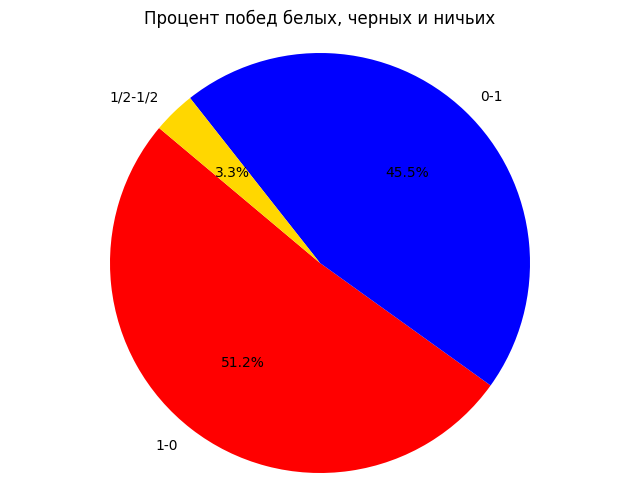

In [12]:
total_games = len(data)
white_wins = len(data[data['result'] == 1])
black_wins = len(data[data['result'] == 2])
draws = len(data[data['result'] == 0])

# Вычисление процента побед каждого типа
white_win_percentage = (white_wins / total_games) * 100
black_win_percentage = (black_wins / total_games) * 100
draw_percentage = (draws / total_games) * 100

# Построение графика
labels = ['1-0', '0-1', '1/2-1/2']
sizes = [white_win_percentage, black_win_percentage, draw_percentage]
colors = ['red','blue','gold']
# explode = (0.1, 0, 0)  # Выделение первого сегмента

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Задает равное соотношение сторон, чтобы график выглядел как круг
plt.title('Процент побед белых, черных и ничьих')
plt.show()

По полученному графику видно, что результат соответсвует ожидаемому, а, значит, датасет подходит для исследования поставленного вопроса.

# Влияние типа игры на результат партии

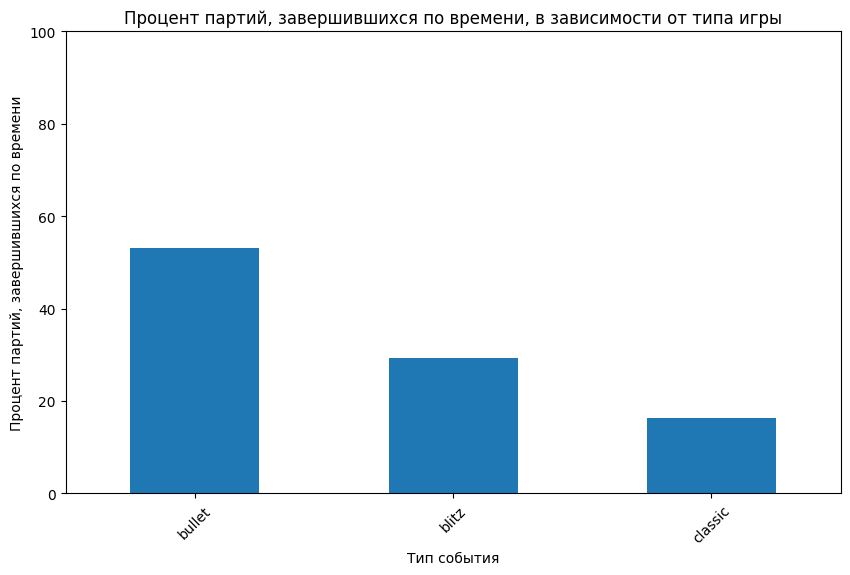

In [13]:
new_labels = ['bullet', 'blitz', 'classic']

# Группировка данных по типу события и подсчет процента партий, завершившихся по времени, для каждого типа события
time_forfeit_by_event = data.groupby('event')['termination'].apply(lambda x: (x == 0).mean() * 100)

# Построение графика
plt.figure(figsize=(10, 6))
time_forfeit_by_event.plot(kind='bar')
plt.title('Процент партий, завершившихся по времени, в зависимости от типа игры')
plt.xlabel('Тип события')
plt.ylabel('Процент партий, завершившихся по времени')
plt.xticks(range(len(new_labels)), new_labels, rotation=45)  # Замена подписей на новые
plt.ylim(0, 100)
plt.show()

По полученному графику видно, что при игре в пулю (меньше 3 минут) количество партий завершающихся по времени больше половины, что делает результат игры в данном случае более подверженным случайности

## Обучение модели

# Knn
в превую очередь обучим модель knn

In [33]:
features = data[['event','base_time','white_black_diff','increment','black_elo','white_elo']]
target = data['result']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k = 5 
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)


И выведем результаты обучения:

In [34]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5872576177285319
Confusion Matrix:
 [[   6  475  342]
 [  95 8228 4059]
 [  92 4920 5970]]


Получаем точность порядка 58%. Этот результат хочется улучшить, для этого попробуем обучить модель логистической регрессии и сравнить результаты.





# Логистическая регрессия

Теперь обучим модель логистической регрессии, для сравнения результата с Knn.

In [35]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_scaled, y_train)

y_pred_logistic = logistic_regression.predict(X_test_scaled)

accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
conf_matrix = confusion_matrix(y_test, y_pred)


print("Accuracy:", accuracy_logistic)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.6409228097738454
Confusion Matrix:
 [[   6  475  342]
 [  95 8228 4059]
 [  92 4920 5970]]


По полученным данным видно, что точность модели незначительно выше, чем у Knn (64% вместо 58%)

Рассмотрим влияние каждого параметра на нашу модель:

In [36]:
coefficients = logistic_regression.coef_

for i, coef in enumerate(coefficients[0]):
    print(f"Feature {i}: {coef}")


Feature 0: 0.13433505480837804
Feature 1: -0.021524967651949063
Feature 2: -0.004044011099225564
Feature 3: -0.01003464449143304
Feature 4: 0.07545637576262568
Feature 5: 0.07327319767356405


Видно что параметр white_black_diff имеет наименьший модуль и, значит, оказывает наименьшее влияние на нашу модель. Это связано с тем, что практически во всех партиях разница в рейтинге незначительна, благодаря работе системы подбора матчей на lischess

Рассмотрим что произойдет, если исключить это поле из набора данных

In [37]:
features = data[['event','black_elo','white_elo']]
target = data['result']

# Разделяем данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Масштабируем признаки (это важно для KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_scaled, y_train)

# Предсказываем результаты на тестовом наборе
y_pred_logistic = logistic_regression.predict(X_test_scaled)

# Оцениваем метрики для модели логистической регрессии
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
conf_matrix = confusion_matrix(y_test, y_pred)

# Выводим метрики
print("Метрики для модели логистической регрессии:")
print("Accuracy:", accuracy_logistic)
print("Confusion Matrix:\n", conf_matrix)

Метрики для модели логистической регрессии:
Accuracy: 0.640592053582503
Confusion Matrix:
 [[   6  475  342]
 [  95 8228 4059]
 [  92 4920 5970]]


Как видно из полученных результатов исключение этих параметров уменьшает точность модели менее чем на 1%

Попробуем увеличить точность модели путем добавления еще одного параметра, а именно разыгранного дебюта.

Для этого сначала приведем это поле в подходящий вид

In [38]:
data['opening'] = data['opening'].str.split(':').str[0].str.strip()
data.head()

,event,result,white_elo,black_elo,termination,opening,base_time,increment,white_black_diff
0,2,1,1639.0,1403.0,1,French Defense,600,8,236.0
1,2,1,1654.0,1919.0,1,Queen's Pawn Game,480,2,-265.0
2,2,1,1643.0,1747.0,1,Four Knights Game,420,17,-104.0
3,0,2,1824.0,1973.0,1,Caro-Kann Defense,60,1,-149.0
4,0,2,1765.0,1815.0,1,French Defense,60,1,-50.0


In [40]:
data_encoded = pd.get_dummies(data, columns=['opening'])
data_encoded.head()

,event,result,white_elo,black_elo,termination,base_time,increment,white_black_diff,opening_Alekhine Defense,opening_Alekhine Defense #2,...,opening_Van Geet Opening,opening_Van't Kruijs Opening,opening_Vienna Game,opening_Vienna Game #2,opening_Vulture Defense,opening_Wade Defense,opening_Ware Defense,opening_Ware Opening,opening_Yusupov-Rubinstein System,opening_Zukertort Opening
0,2,1,1639.0,1403.0,1,600,8,236.0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,1,1654.0,1919.0,1,480,2,-265.0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,1,1643.0,1747.0,1,420,17,-104.0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,2,1824.0,1973.0,1,60,1,-149.0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,2,1765.0,1815.0,1,60,1,-50.0,False,False,...,False,False,False,False,False,False,False,False,False,False


И, теперь, обучим нашу модель по новым данным, включающим информацию о дебюте

In [41]:
features = data_encoded.drop(columns=['result'])
target = data_encoded['result']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Масштабируем признаки (это важно для KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_scaled, y_train)

# Предсказываем результаты на тестовом наборе
y_pred_logistic = logistic_regression.predict(X_test_scaled)

# Оцениваем метрики для модели логистической регрессии
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
conf_matrix = confusion_matrix(y_test, y_pred)

# Выводим метрики
print("Метрики для модели логистической регрессии:")
print("Accuracy:", accuracy_logistic)
print("Confusion Matrix:\n", conf_matrix)

Метрики для модели логистической регрессии:
Accuracy: 0.6416256666804482
Confusion Matrix:
 [[   6  475  342]
 [  95 8228 4059]
 [  92 4920 5970]]


Видно, что знание о разыгранном дебюте, в рамках данной модели, практически не влияет на точность

Сравним полученные значения с элементарной моделью, выбирающей наиболее частый класс (победу белых)

In [44]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_scaled, y_train)
y_dummy_pred = dummy_clf.predict(X_test_scaled)

dummy_accuracy = accuracy_score(y_test, y_dummy_pred)

print("Accuracy:", dummy_accuracy)


Метрики для базовой модели:
Accuracy: 0.5119278951502874


Как видно, полученная модель логистической регрессии значительно превосходит тривиальный пример.